# CAS Project: The Pendlulum Swing-up problem with Q-Learning
    Name: Michael, Cornelisse
    Student #: s1059020

## Install & Import needed libraries

In [1]:
!pip install gymnax

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.nn as jnn
from jax.random import PRNGKey
import optax
import gymnax
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib import animation, rc
from IPython.display import HTML
%matplotlib inline

## Pendulum Environment Setup

In [3]:
# Environment Setup
key = PRNGKey(1337)
key, key_reset, key_action, key_step = jr.split(key, 4)

# Create the Pendulum-v1 environment
env_name = "Pendulum-v1"
env, env_params = gymnax.make(env_name)

# Inspect default environment settings
print(env_params)
ts = jnp.arange(0, env_params.dt * env_params.max_steps_in_episode, env_params.dt)

obs, state = env.reset(key_reset, env_params)

EnvParams(max_steps_in_episode=200, max_speed=8.0, max_torque=2.0, dt=0.05, g=10.0, m=1.0, l=1.0)


### Discretize the action space

In [4]:
# Discretize the action space
obs, state = env.reset(key_reset)
action = env.action_space().sample(key_action)
action_list = jnp.array([-1., 0., 1.])
num_actions = len(action_list)

## Neural Network Setup

In [5]:
def initialize_mlp(layer_sizes, key:PRNGKey, scale:float=1e-2):
    """
    Inputs:
        layer_sizes (tuple) Tuple of shapes of the neural network layers. Includes the input shape, hidden layer shape, and output layer shape.
        key (PRNGKey)
        scale (float) standard deviation of initial weights and biases

    Return:
        params (List) Tuple of weights and biases - [ (weights_1, biases_1), ..., (weights_n, biases_n) ]
    """
    params = []
    for i in range(len(layer_sizes)-1):
        key, subkey_w, subkey_b = jr.split(key, 3)
        weights = scale * jr.normal(subkey_w, shape=(layer_sizes[i], layer_sizes[i+1]))
        biases = scale * jr.normal(subkey_b, shape=(layer_sizes[i+1],))
        params.append((weights, biases))
    return params

def q_network(params, x):
    """
    Forward pass of the Q-network (no softmax).
    Returns Q-values for each discrete action (shape (num_actions,)).
    """
    for weights, biases in params[:-1]:
        x = jnn.relu(jnp.dot(x, weights) + biases)
    final_weights, final_biases = params[-1]
    q_values = jnp.dot(x, final_weights) + final_biases
    return q_values

## Epsilon Greedy Action Selection

In [6]:
@jax.jit
def epsilon_greedy(q_values, epsilon, key_rand):
    """
    With probability epsilon, pick a random action;
    else pick the action that maximizes Q-values.
    """
    rand_val = jr.uniform(key_rand, ())
    action_idx = jnp.where(
        rand_val < epsilon,
        jr.randint(key_rand, shape=(), minval=0, maxval=len(action_list)),
        jnp.argmax(q_values)
    )
    action_idx = action_idx.astype(int)
    action = action_list[action_idx]
    return action_idx, action

### Helper function for linear epsilon decay

In [7]:
# Helper function to linearly decay epsilon
def linear_epsilon_decay(step, initial_epsilon, final_epsilon, epsilon_decay_steps):
    fraction = min(1.0, float(step) / epsilon_decay_steps)
    return initial_epsilon + fraction * (final_epsilon - initial_epsilon)

## Loss Functions

In [8]:
# Loss Function
def mse_td_loss(params_online, params_target, batch, gamma):
    states, actions, rewards, next_states, dones = batch

    # Q-values from ONLINE network (for current states)
    q_vals = jax.vmap(q_network, in_axes=(None, 0))(params_online, states)
    q_chosen = jax.vmap(lambda q, a: q[a])(q_vals, actions)

    # Next-state Q-values from TARGET network
    q_next_vals_target = jax.vmap(q_network, in_axes=(None, 0))(params_target, next_states)
    max_next_q = jnp.max(q_next_vals_target, axis=1)

    # TD target
    td_target = rewards + gamma * (1.0 - dones) * max_next_q
    loss = jnp.mean((q_chosen - td_target)**2)
    return loss

# We'll JIT the gradient wrt. online params only (argnums=0).
mse_loss_and_grads_fn = jax.jit(jax.value_and_grad(mse_td_loss, argnums=0))

## Replay Buffer

In [9]:
class ReplayBuffer:
    def __init__(self, capacity, obs_dim):
        self.capacity = capacity
        self.obs_dim = obs_dim
        self.ptr = 0
        self.size = 0

        self.states = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.actions = np.zeros((capacity,), dtype=np.int32)
        self.rewards = np.zeros((capacity,), dtype=np.float32)
        self.next_states = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.dones = np.zeros((capacity,), dtype=np.float32)

    def push(self, s, a, r, s_next, done):
        self.states[self.ptr] = s
        self.actions[self.ptr] = a
        self.rewards[self.ptr] = r
        self.next_states[self.ptr] = s_next
        self.dones[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size, rng: jr.PRNGKey):
        idxs = jr.randint(rng, shape=(batch_size,), minval=0, maxval=self.size)
        batch = (
            jnp.array(self.states[idxs]),
            jnp.array(self.actions[idxs]),
            jnp.array(self.rewards[idxs]),
            jnp.array(self.next_states[idxs]),
            jnp.array(self.dones[idxs]),
        )
        return batch

## Model Training & Experiments

### Hyperparameters

In [10]:
num_episodes = 600            # Total number of episodes to train for
max_steps_per_episode = 200   # Maximum number of steps in one episode
gamma = 0.99                  # Discount factor
learning_rate = 5e-4          # Learning rate for the optimizer
buffer_size = 10000           # Replay buffer size
batch_size = 128              # Batch size for training
initial_epsilon = 0.9         # Initial exploration rate
final_epsilon = 0.05          # Final exploration rate
epsilon_decay_steps = 1000    # Number of steps for epsilon decay
tau = 0.005                   # Soft update parameter for target network
warmup_steps = 1000            # Number of steps for the warm-up phase

# Network Parameters
obs_dim =  obs.shape[0]
layer_sizes = (obs_dim, 128, 128, num_actions)

# 2. Initialize Networks
key, key_params_online, key_params_target = jr.split(key, 3)
params_online = initialize_mlp(layer_sizes, key_params_online)
params_target = initialize_mlp(layer_sizes, key_params_target)

# 3. Initialize Optimizer
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params_online)

# 4. Initialize Replay Buffer
replay_buffer = ReplayBuffer(buffer_size, obs_dim)

print("Hyperparameters and initialization complete!")

Hyperparameters and initialization complete!


### Train Step function

In [11]:
# JIT-compiled training step
@jax.jit
def train_step(params_online, params_target, opt_state, batch, tau):
    loss, grads = mse_loss_and_grads_fn(params_online, params_target, batch, gamma)
    updates, opt_state = optimizer.update(grads, opt_state, params_online)
    params_online = optax.apply_updates(params_online, updates)
    # Soft update of target network (polyak averaging)
    params_target = optax.incremental_update(params_online, params_target, tau)
    return params_online, params_target, opt_state, loss

### Main Training Loop

In [12]:
episode_returns = []
losses = []
global_step = 0

for episode in tqdm(range(num_episodes)):
  # Reset environment
  key, key_reset, key_action_warm_up, key_action, key_step, key_replay = jr.split(key, 6)

  state, env_state = env.reset(key_reset, env_params)
  episode_return = 0.0
  loss = 0.0
  episode_loss = []
  for step in range(max_steps_per_episode):
    global_step += 1

    # Warm-up Phase (Random Actions)
    if global_step <= warmup_steps:
      # Sample random action index
      key_action_warm_up, key_action_warm_up_sub = jr.split(key_action_warm_up, 2)
      action_idx = jr.randint(key_action_warm_up_sub, shape=(), minval=0, maxval=num_actions)
      action = action_list[action_idx]
    else:
      # Epsilon Decay (after warm-up)
      epsilon = linear_epsilon_decay(global_step - warmup_steps, initial_epsilon, final_epsilon, epsilon_decay_steps)

      # Action Selection (Epsilon-Greedy after warm-up)
      key_action, key_action_sub = jr.split(key_action, 2)
      q_values = q_network(params_online, state)
      action_idx, action = epsilon_greedy(q_values, epsilon, key_action_sub)

    # Step in Environment
    key_step, key_step_sub = jr.split(key_step, 2)
    next_state, env_state, reward, done, info = env.step(key_step_sub, env_state, action, env_params)

    # Store in Replay Buffer
    replay_buffer.push(state, action_idx, reward, next_state, done)  # Store action index

    # Sample from Replay Buffer and Train (after warm-up)
    if global_step > warmup_steps and replay_buffer.size > batch_size:
      key_replay, key_sample = jr.split(key_replay, 2)
      batch = replay_buffer.sample(batch_size, key_sample)
      params_online, params_target, opt_state, loss = train_step(params_online, params_target, opt_state, batch, tau)
      episode_loss.append(loss)

    # Update Current State
    state = next_state
    episode_return += reward

    # Check if episode is done
    if done:
      break

  # Track Progress
  if episode_loss:
    average_loss = sum(episode_loss) / len(episode_loss)
    losses.append(average_loss)
  else:
    average_loss = None

  episode_returns.append(episode_return)
  if episode % 25 == 0:
      print(f"Episode: {episode+1}, Return: {episode_return}, Average Loss: {average_loss}, Epsilon: {epsilon if global_step > warmup_steps else 'N/A (Warm-up)'}")

print("Training complete!")

  0%|          | 2/600 [00:01<04:35,  2.17it/s]

Episode: 1, Return: -1568.894775390625, Average Loss: None, Epsilon: N/A (Warm-up)


  4%|▍         | 26/600 [00:12<04:31,  2.12it/s]

Episode: 26, Return: -759.322998046875, Average Loss: 63.581233978271484, Epsilon: 0.050000000000000044


  8%|▊         | 51/600 [00:24<04:30,  2.03it/s]

Episode: 51, Return: -1099.7744140625, Average Loss: 173.96176147460938, Epsilon: 0.050000000000000044


 13%|█▎        | 76/600 [00:36<04:11,  2.09it/s]

Episode: 76, Return: -1495.8446044921875, Average Loss: 139.22584533691406, Epsilon: 0.050000000000000044


 17%|█▋        | 101/600 [00:49<04:01,  2.06it/s]

Episode: 101, Return: -909.4313354492188, Average Loss: 97.09770202636719, Epsilon: 0.050000000000000044


 21%|██        | 126/600 [01:00<03:44,  2.11it/s]

Episode: 126, Return: -244.26487731933594, Average Loss: 60.97781753540039, Epsilon: 0.050000000000000044


 25%|██▌       | 151/600 [01:12<03:35,  2.08it/s]

Episode: 151, Return: -246.5528564453125, Average Loss: 48.143001556396484, Epsilon: 0.050000000000000044


 29%|██▉       | 176/600 [01:24<03:22,  2.10it/s]

Episode: 176, Return: -122.68871307373047, Average Loss: 8.63748550415039, Epsilon: 0.050000000000000044


 34%|███▎      | 201/600 [01:36<03:10,  2.09it/s]

Episode: 201, Return: -241.4444122314453, Average Loss: 9.68716049194336, Epsilon: 0.050000000000000044


 38%|███▊      | 226/600 [01:48<02:57,  2.11it/s]

Episode: 226, Return: -126.10122680664062, Average Loss: 7.954498291015625, Epsilon: 0.050000000000000044


 42%|████▏     | 251/600 [02:00<02:44,  2.13it/s]

Episode: 251, Return: -123.5113754272461, Average Loss: 5.004450798034668, Epsilon: 0.050000000000000044


 46%|████▌     | 276/600 [02:12<02:38,  2.05it/s]

Episode: 276, Return: -122.48542785644531, Average Loss: 4.17294979095459, Epsilon: 0.050000000000000044


 50%|█████     | 301/600 [02:24<02:23,  2.08it/s]

Episode: 301, Return: -359.31146240234375, Average Loss: 2.5654942989349365, Epsilon: 0.050000000000000044


 54%|█████▍    | 326/600 [02:36<02:10,  2.10it/s]

Episode: 326, Return: -241.548095703125, Average Loss: 1.7220667600631714, Epsilon: 0.050000000000000044


 58%|█████▊    | 351/600 [02:49<02:01,  2.04it/s]

Episode: 351, Return: -485.2741394042969, Average Loss: 2.069561243057251, Epsilon: 0.050000000000000044


 63%|██████▎   | 376/600 [03:01<01:46,  2.10it/s]

Episode: 376, Return: -251.05776977539062, Average Loss: 2.3476145267486572, Epsilon: 0.050000000000000044


 67%|██████▋   | 401/600 [03:13<01:37,  2.05it/s]

Episode: 401, Return: -121.39270782470703, Average Loss: 1.994285225868225, Epsilon: 0.050000000000000044


 71%|███████   | 426/600 [03:25<01:22,  2.12it/s]

Episode: 426, Return: -235.6017608642578, Average Loss: 1.9052228927612305, Epsilon: 0.050000000000000044


 75%|███████▌  | 451/600 [03:37<01:11,  2.08it/s]

Episode: 451, Return: -243.84454345703125, Average Loss: 1.8565541505813599, Epsilon: 0.050000000000000044


 79%|███████▉  | 476/600 [03:49<01:00,  2.05it/s]

Episode: 476, Return: -0.5465863943099976, Average Loss: 1.7987890243530273, Epsilon: 0.050000000000000044


 84%|████████▎ | 501/600 [04:01<00:47,  2.07it/s]

Episode: 501, Return: -124.16487121582031, Average Loss: 2.059401512145996, Epsilon: 0.050000000000000044


 88%|████████▊ | 526/600 [04:13<00:36,  2.04it/s]

Episode: 526, Return: -578.162353515625, Average Loss: 1.7199349403381348, Epsilon: 0.050000000000000044


 92%|█████████▏| 551/600 [04:25<00:23,  2.12it/s]

Episode: 551, Return: -121.31278991699219, Average Loss: 1.5099647045135498, Epsilon: 0.050000000000000044


 96%|█████████▌| 576/600 [04:37<00:11,  2.09it/s]

Episode: 576, Return: -234.5644989013672, Average Loss: 1.3784496784210205, Epsilon: 0.050000000000000044


100%|██████████| 600/600 [04:48<00:00,  2.08it/s]

Training complete!


### Plot training rewards

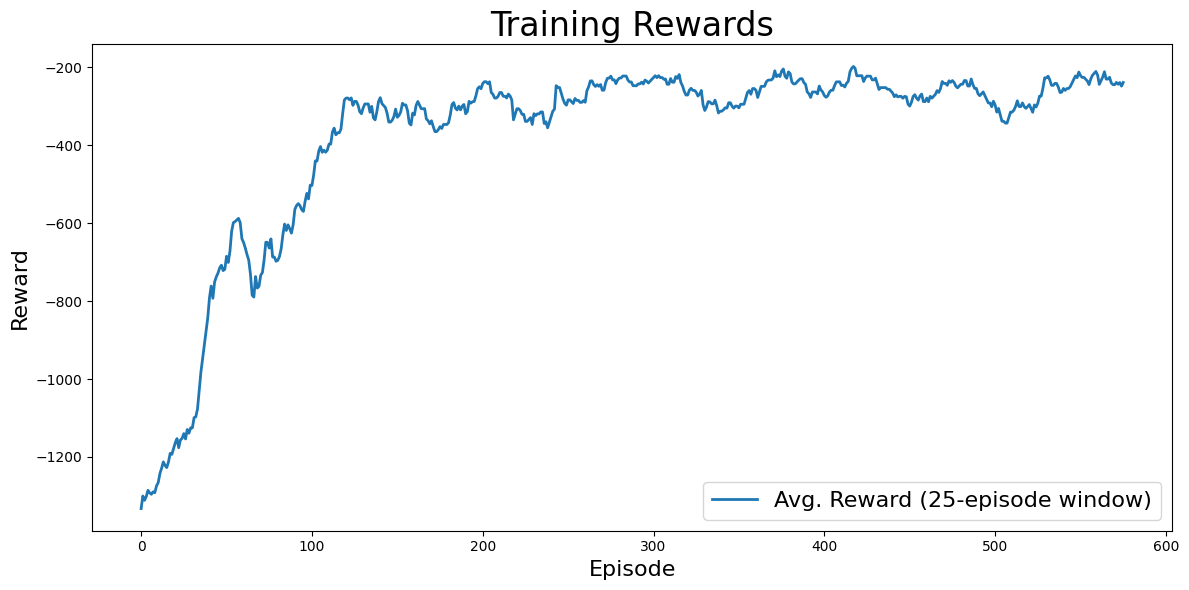

In [43]:
# Plot episode rewards
plt.figure(figsize=(12, 6))
plt.plot(np.convolve(episode_returns, np.ones(25)/25, mode='valid'), label='Avg. Reward (25-episode window)', linewidth=2) # Increased linewidth and added color
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Reward", fontsize=16)
plt.title("Training Rewards", fontsize=24)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

### Plot Training losses

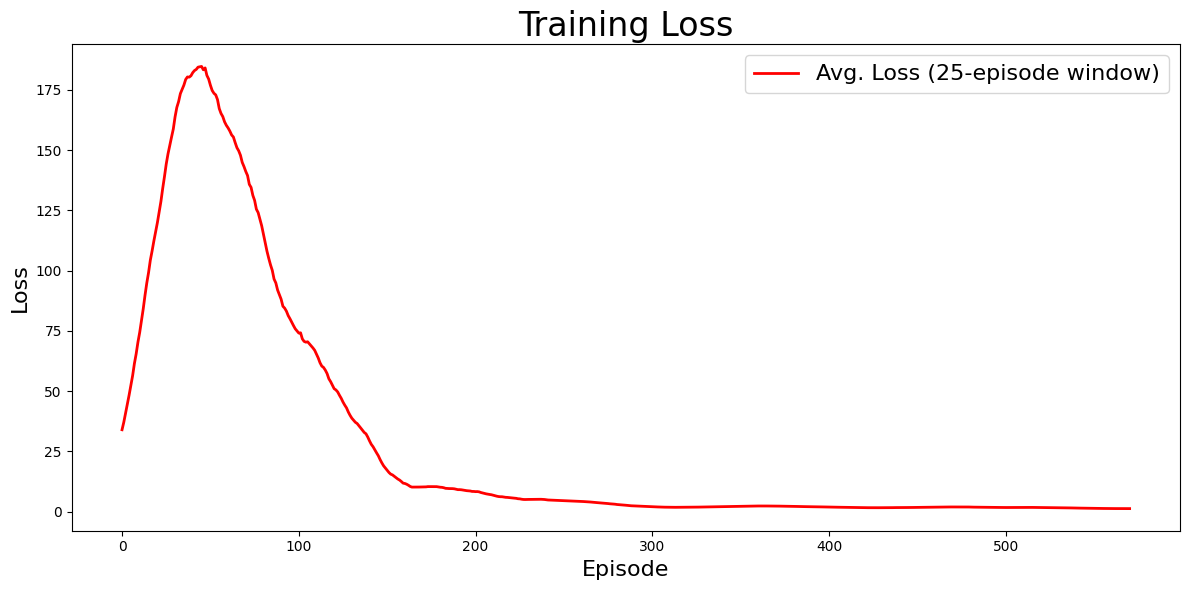

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(np.convolve(losses, np.ones(25)/25, mode='valid'), label='Avg. Loss (25-episode window)', linewidth=2, color='red')  # Increased linewidth and color
plt.xlabel("Episode", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Training Loss", fontsize=24)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()

## Evaluation

In [15]:
def evaluate_agent(params, env_params, rng_input, steps_in_episode):
    """Rollout a jitted gymnax episode with lax.scan."""
    rng_reset, rng_episode = jr.split(rng_input)
    obs, state = env.reset(rng_reset, env_params)

    def value_based_step(state_input, _):
        """lax.scan compatible step transition in jax env."""
        obs, state, rng = state_input
        rng, rng_action, rng_step = jr.split(rng, 3)
        q_vals = q_network(params, obs)
        action_idx = jnp.argmax(q_vals)
        action = action_list[action_idx]
        next_obs, next_state, reward, done, _ = env.step(rng_step, state, action, env_params)
        carry = [next_obs, next_state, rng]
        return carry, [obs, state, action, action_idx, reward, next_obs, done]

    _, scan_out = jax.lax.scan(
        value_based_step,
        [obs, state, rng_episode],
        (),
        length=steps_in_episode,
    )
    return scan_out

jit_evaluate_agent = jax.jit(evaluate_agent, static_argnums=3)

### Visualization methods

In [16]:
def visualize_trajectory(params, key):
    obs, state, action, action_idx, reward, next_obs, done = jit_evaluate_agent(params, env_params, rng_input=key, steps_in_episode=env_params.max_steps_in_episode)

    fig, ax = plt.subplots(5,1,figsize=(8,8))
    # first three plots for the system states
    ax[0].set_title('System states over time')

    for d in range(obs_dim):
        ax[d].plot(ts, obs[:,d], color='C0', label=f'State {d}')
    ax[0].set_title(r'$\cos(\theta)$')
    ax[1].set_title(r'$\sin(\theta)$')
    ax[2].set_title(r'$\dot{\theta}$')

    ax[3].plot(ts, action, color='C1', label=f'Actions')
    # ax[3].set_ylim((env.action_space().low, env.action_space().high))
    ax[3].set_title('u(t)')
    ax[4].plot(ts, reward, color='C2', label='Rewards')
    ax[4].set_title('r(t)')

    plt.tight_layout()
    plt.show()

In [44]:
def animate_pendulum(params, key):
    obs, _, _, _, _, _, _ = jit_evaluate_agent(
        params, env_params, rng_input=key, steps_in_episode=env_params.max_steps_in_episode
    )

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(f"Final Pendulum Position")
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_aspect('equal')

    line, = ax.plot([], [], 'o-',color="r", lw=2, markersize=10)

    def init():
        line.set_data([], [])
        return (line,)

    def animate(i):
        x = obs[i, 1]          # = sin(theta)
        y = obs[i, 0]          # = cos(theta)
        line.set_data([0, x], [0, y])

        return (line,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(obs), interval=60, blit=True)

    rc('animation', html='jshtml')
    return anim

### Evaluation plots

In [18]:
key, subkey_vis, subkey_anim = jr.split(key, 3)

Caption 1: Single rollout using the policy network with training


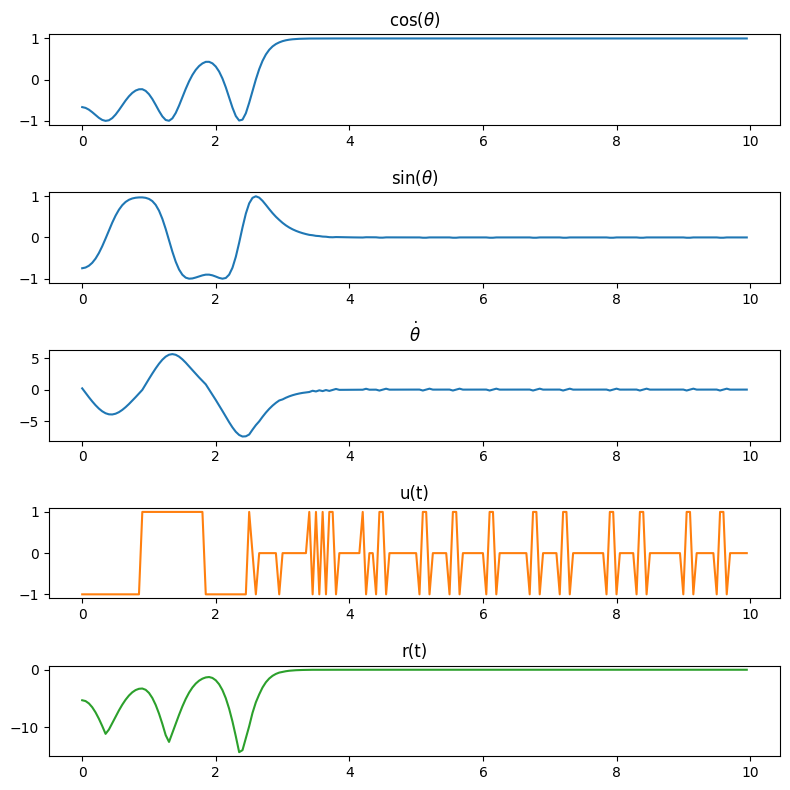

In [19]:
print('Caption 1: Single rollout using the policy network with training')
visualize_trajectory(params_online, subkey_vis)

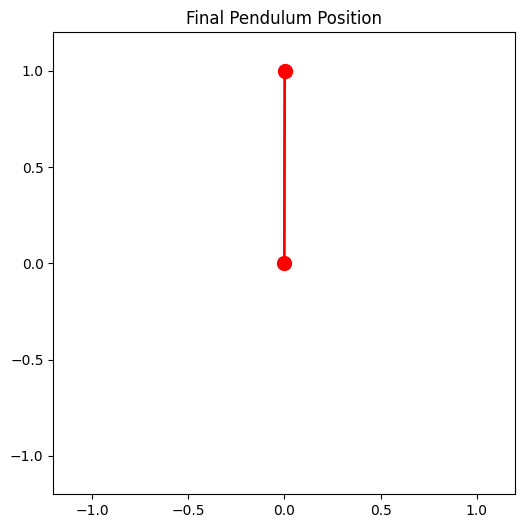

In [20]:
#key, subkey_anim = jr.split(key)
anim = animate_pendulum(params_online, subkey_anim)
HTML(anim.to_jshtml()) # Display the animation